# Using FDTD to Compute a Transmission Spectrum
In this lecture, we show how to use FDTD to solve a basic EM problem involving the transmission of light though a slab of material.

- How to set up the simulation using periodic boundary conditions and a plane wave source.
- How to use a broadband pulse to compute the normalized transmission over a range of wavelengths.
- How the FDTD results agree with those computed with analytical methods.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

In [2]:
# Wavelength and frequency range
freq_range = (200e12, 400e12)
lambda_range = (td.constants.C_0/freq_range[1], td.constants.C_0/freq_range[0])
freq0 = np.sum(freq_range)/2
Nfreq = 301

# frequencies and wavelengths of monitor
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# central frequency, frequency pulse width and total running time
lambda0 = td.C_0 / freq0
bandwidth = 0.18  # bandwidth of source in units of delta frequency.  0.38 for broadband

freqw  = bandwidth * (freq_range[1] - freq_range[0])
t_stop = 100 / freq0

# Thickness and refractive index of slab
t_slab = 0.5
n_slab = 3.5
mat_slab = td.Medium(permittivity=n_slab**2, name='silicon')

# Grid resolution (cells per um)
# dl = lambda_range[0] / 30 / n_slab
dl = 6e-3

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (2.0, 2.0, 2*spacing + t_slab)

In [3]:
def slab_analytical(d, n, wvl):
    """ computes transmision as a function of slab thickness (d), refractive index (n), and wavelength (wvl). """
    rho = (n-1)/(n+1)
    t = ((1+rho)*(1-rho)*np.exp(-2j*np.pi*n*d/wvl)) / (1 - rho**2*np.exp(-4j*np.pi*n*d/wvl))
    return np.abs(t)**2

transmission_analytical = slab_analytical(t_slab, n_slab, monitor_lambdas)

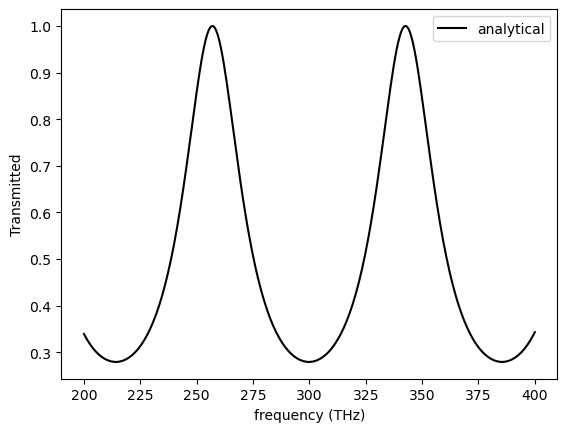

In [4]:
plt.figure()
plt.plot(monitor_freqs / 1e12, transmission_analytical, 'k', label='analytical')
plt.xlabel('frequency (THz)')
plt.ylabel('Transmitted')
plt.legend()
plt.show()

In [5]:
# define the multilayer stack structure
slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, -Lz/2 + spacing + t_slab/2),
        size=(td.inf, td.inf, t_slab),
    ),
    medium=mat_slab,
    name='slab',
)

In [6]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2+spacing/2),
    direction='+',
    pol_angle=0,
    name='planewave',
)

In [7]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='flux',
)

In [8]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures = [slab],
    sources = [source],
    monitors = [monitor],
    run_time = t_stop,
    boundary_spec = td.BoundarySpec.pml(z=True),
    normalize_index = None,
)

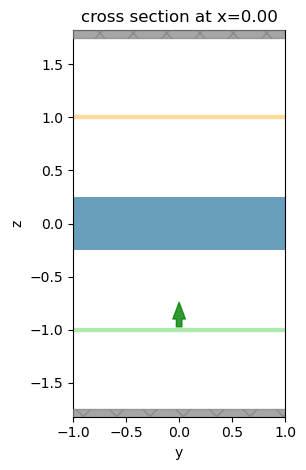

In [9]:
sim.plot(x=0)
plt.show()

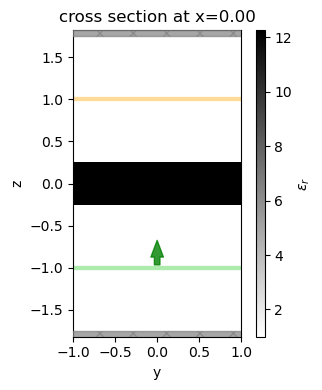

In [10]:
# plot the permittivity 
freqs_plot = (freq_range[0], freq_range[1])
fig, ax = plt.subplots(1, tight_layout=True, figsize=(8, 4))
sim.plot_eps(x=0, freq=None, ax=ax)
plt.show()

In [11]:
times = np.arange(0, sim.run_time, sim.dt)
amps = np.real(sim.sources[0].source_time.amp_time(times))

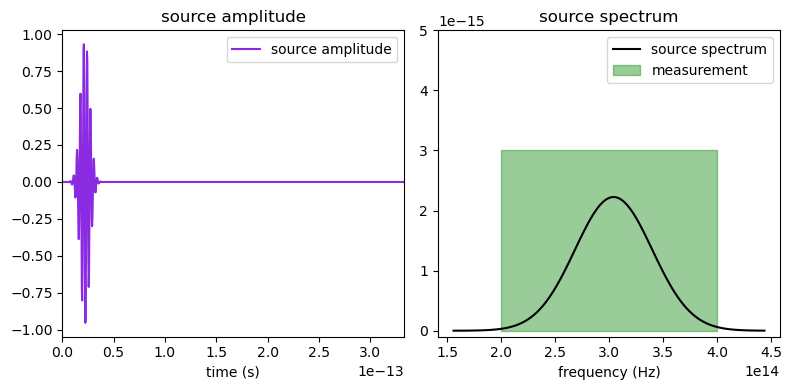

In [12]:
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, sim.run_time, 1001), ax=ax1)
ax1.set_xlim(0, sim.run_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 1001), val='abs', ax=ax2)
fill_max = 30e-16 # 10e-16
ymax = 50e-16 # 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [13]:
sim0 = sim.copy(update={'structures':[]})

In [14]:
sim_data0 = web.run(sim0, task_name='lecture02_slab_narrowband_normalization', path=f'data/data0_narrowband.hdf5', verbose=True)
sim_data = web.run(sim, task_name='lecture02_slab_narrowband_transmission', path=f'data/data_narrowband.hdf5', verbose=True)

21:57:33 +07 Created task 'lecture02_slab_narrowband_normalization' with task_id
             'fdve-60b9b087-d277-49de-ab8a-932c06988463' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=825124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=440202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\taskId]8;;\]8;id=825124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\=]8;;\]8;id=146272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\fdve]8;;\]8;id=825124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\-60b9b087-d27]8;;\
             ]8;id=825124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\7-49de-ab8a-932c06988463']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

21:57:36 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

21:57:50 +07 status = preprocess

21:57:52 +07 Maximum FlexCredit cost: 0.595. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

21:58:08 +07 early shutoff detected at 16%, exiting.

             status = postprocess

             status = success

21:58:09 +07 View simulation result at                                          
             ]8;id=115700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=288454;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\taskId]8;;\]8;id=115700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\=]8;;\]8;id=513644;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\fdve]8;;\]8;id=115700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\-60b9b087-d27]8;;\
             ]8;id=115700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60b9b087-d277-49de-ab8a-932c06988463\7-49de-ab8a-932c06988463']8;;\.

21:58:10 +07 loading simulation from data/data0_narrowband.hdf5

21:58:11 +07 Created task 'lecture02_slab_narrowband_transmission' with task_id 
             'fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=681037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=767641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\taskId]8;;\]8;id=681037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\=]8;;\]8;id=992655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\fdve]8;;\]8;id=681037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\-fa4eb4c0-e07]8;;\
             ]8;id=681037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\4-4fed-ae35-73a3035d5272']8;;\.

21:58:13 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

21:58:18 +07 status = preprocess

21:58:19 +07 Maximum FlexCredit cost: 0.595. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

21:58:20 +07 running solver

21:58:43 +07 early shutoff detected at 28%, exiting.

             status = postprocess

21:58:44 +07 status = success

             View simulation result at                                          
             ]8;id=943749;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=972383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\taskId]8;;\]8;id=943749;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\=]8;;\]8;id=603224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\fdve]8;;\]8;id=943749;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\-fa4eb4c0-e07]8;;\
             ]8;id=943749;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa4eb4c0-e074-4fed-ae35-73a3035d5272\4-4fed-ae35-73a3035d5272']8;;\.

21:58:46 +07 loading simulation from data/data_narrowband.hdf5

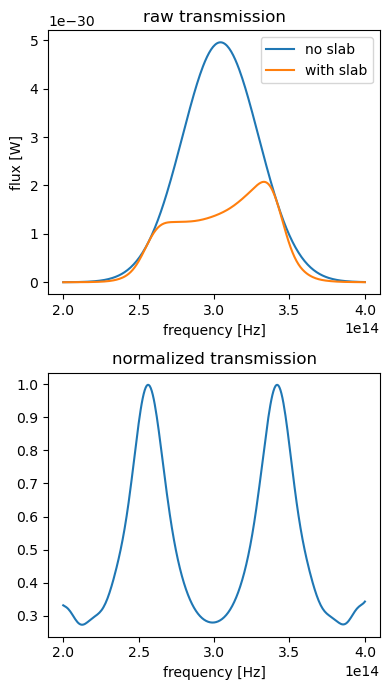

In [15]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_data0['flux'].flux
transmission = sim_data['flux'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

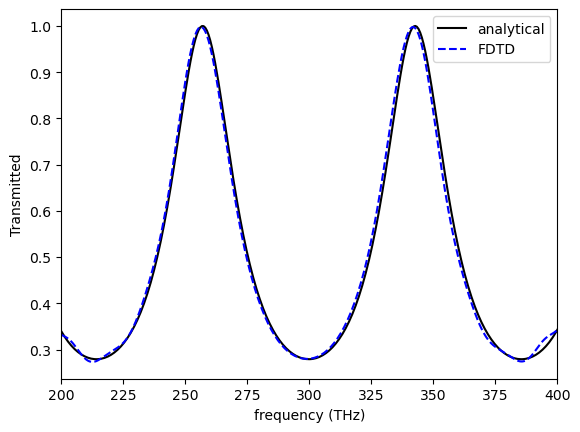

In [16]:
plt.figure()
plt.plot(monitor_freqs/1e12, transmission_analytical, 'k', label='analytical')
plt.plot(monitor_freqs/1e12, transmission_normalized, 'b--', label='FDTD')
plt.xlabel('frequency (THz)')
plt.xlim([200, 400])
plt.ylabel('Transmitted')
plt.legend()
plt.show()

In [17]:
bandwidth = 0.38

freqw  = bandwidth * (freq_range[1] - freq_range[0])

# make a copy of the original simulation, but change the frequency width of the source
bw_source = source.copy(update={
    'source_time':source.source_time.copy(update={'fwidth':freqw})
    }
)
sim_bw = sim.copy(update={'sources':[bw_source]})

# make the normalization simulation for this
sim_bw0 = sim_bw.copy(update={'structures':[]})

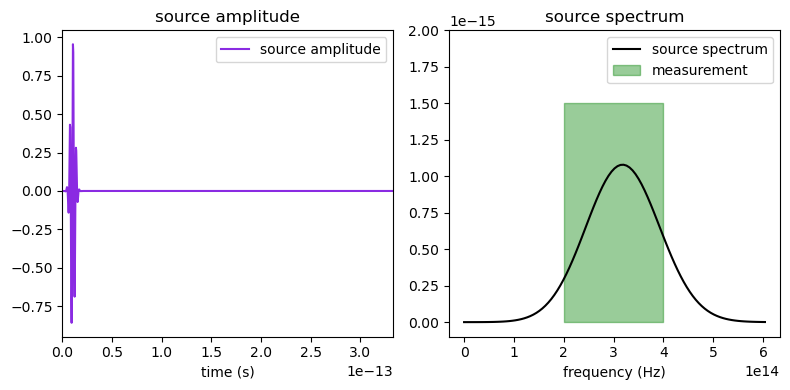

In [18]:
# Check probe and source, looks now like the source spectrum fully covers the green square
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim_bw.sources[0].source_time.plot(times=np.linspace(0, sim_bw.run_time, 1001), ax=ax1)
ax1.set_xlim(0, sim_bw.run_time)
ax1.legend(('source amplitude',))
ax2 = sim_bw.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim_bw.run_time, 1001), val='abs', ax=ax2)
fill_max = 15e-16
ymax = 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [19]:
sim_bw_data0 = web.run(sim_bw0, task_name='lecture02_slab_broadband_normalizatio', path=f'data/data0_broadband.hdf5')
sim_bw_data = web.run(sim_bw, task_name='lecture02_slab_broadband_transmission', path=f'data/data_broadband.hdf5')

21:59:33 +07 Created task 'lecture02_slab_broadband_normalizatio' with task_id  
             'fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=577417;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=576483;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\taskId]8;;\]8;id=577417;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\=]8;;\]8;id=694241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\fdve]8;;\]8;id=577417;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\-a0c8c510-4a5]8;;\
             ]8;id=577417;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\2-49c6-99d8-d430b6bfb373']8;;\.

21:59:36 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

21:59:41 +07 status = preprocess

21:59:43 +07 Maximum FlexCredit cost: 0.597. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

21:59:44 +07 running solver

21:59:56 +07 early shutoff detected at 8%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=853114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=348510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\taskId]8;;\]8;id=853114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\=]8;;\]8;id=869018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\fdve]8;;\]8;id=853114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\-a0c8c510-4a5]8;;\
             ]8;id=853114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0c8c510-4a52-49c6-99d8-d430b6bfb373\2-49c6-99d8-d430b6bfb373']8;;\.

21:59:58 +07 loading simulation from data/data0_broadband.hdf5

             Created task 'lecture02_slab_broadband_transmission' with task_id  
             'fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=450104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=612983;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\taskId]8;;\]8;id=450104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\=]8;;\]8;id=35009;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\fdve]8;;\]8;id=450104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\-c820e998-38e]8;;\
             ]8;id=450104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\e-4631-b5b2-e3a2639abdd3']8;;\.

22:00:01 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

22:00:06 +07 status = preprocess

22:00:08 +07 Maximum FlexCredit cost: 0.597. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

22:00:09 +07 running solver

22:00:32 +07 early shutoff detected at 28%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=158607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=457006;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\taskId]8;;\]8;id=158607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\=]8;;\]8;id=413136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\fdve]8;;\]8;id=158607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\-c820e998-38e]8;;\
             ]8;id=158607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c820e998-38ee-4631-b5b2-e3a2639abdd3\e-4631-b5b2-e3a2639abdd3']8;;\.

22:00:34 +07 loading simulation from data/data_broadband.hdf5

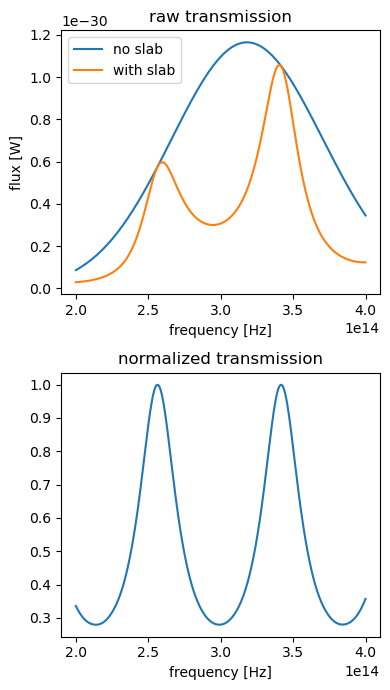

In [20]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_bw_data0['flux'].flux
transmission = sim_bw_data['flux'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

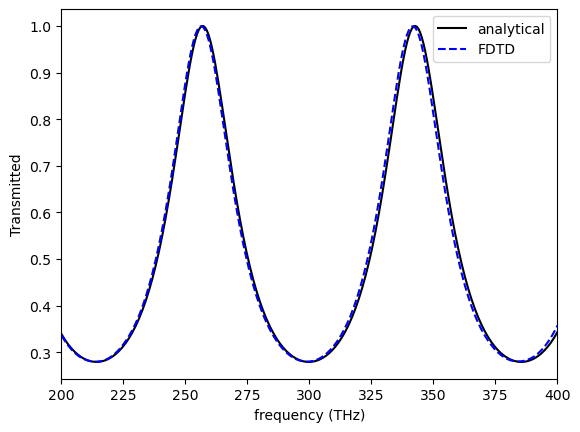

In [21]:
plt.figure()
plt.plot(monitor_freqs/1e12, transmission_analytical, 'k', label='analytical')
plt.plot(monitor_freqs/1e12, transmission_normalized, 'b--', label='FDTD')
plt.xlabel('frequency (THz)')
plt.xlim([200, 400])
plt.ylabel('Transmitted')
plt.legend()
plt.show()